# SeasFire Datacube access and basic analytics

This notebook shows basic utilities to load and process the SeasFire DataCube with xarray. It contains basic instructions showing how to access, process and visualize the data.

- Python 3.10.12
- numpy==1.26.4
- matplotlib==3.7.1
- xarray==2024.6.0
- zarr==2.18.2

## Initial Imports

We start by importing the libraries we need. Make sure to have them installed in your system, using conda or pip packaging systems.

In [1]:
# Install zarr 2.18.2 which is not readily available for import in the google colab environment as of 2024.
!pip install zarr==2.18.2 > /dev/null 2>&1  # > /dev/null 2>&1 ensures silent download without displaying the installation logs in the output cell.

In [2]:
# Import lib
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import zarr
import zipfile
import os
import os
import zipfile
import xarray as xr
from tqdm import tqdm
import requests
import time

## Download and Access DataCube

We download the datacube from SeasFire DataCube in the form of a zarr file from Zenodo and Google drive.  
- Download complete dataset from [Zenodo version 1](https://zenodo.org/record/6834585)

Please note: for version 2 and version 3 of the dataset, you would need access to use alternative resources as they exceed 100 GB when unzipped and lead to the Google Colab disk being full. The version 1 would take between 15-20 minutes on ~ 50 Mbps internet speed. The free tier of Google Colab only allots 100 GB of free disk space.


In [8]:
def download_with_progress(url, destination):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kilobyte

    start_time = time.time()

    with open(destination, 'wb') as file, tqdm(
        total=total_size, unit='iB', unit_scale=True, desc=destination, ncols=100, leave=True,
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"
    ) as bar:
        for data in response.iter_content(block_size):
            file.write(data)
            bar.update(len(data))

def get_version_1_of_seasfire_datacube():
    try:
        # Download zipped cube
        url = "https://zenodo.org/records/6834585/files/SeasFireCube8daily.zip"
        zip_filename = "SeasFireCube8daily.zip"

        if not os.path.exists(zip_filename):
            print("Downloading data cube...")
            download_with_progress(url, zip_filename)
        else:
            print("Data cube already downloaded.")

        # Extract from zip file with progress bar
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            print("Extracting data cube...")
            total_files = len(zip_ref.namelist())
            with tqdm(total=total_files, unit='file', desc='Extracting', ncols=100, leave=True,
                      bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]") as bar:
                for file in zip_ref.namelist():
                    zip_ref.extract(file)
                    bar.update(1)

        extracted_folder = 'SeasFireCube8daily.zarr'
        if not os.path.exists(extracted_folder):
            raise FileNotFoundError(f"Extraction failed, {extracted_folder} not found.")

        # Load dataset
        dataset = xr.open_zarr(extracted_folder)
        print("Dataset successfully loaded.")
        return dataset

    except Exception as e:
        print(f"An error occurred while downloading or loading the data cube: {e}")
        return None

def get_dataset_attributes(dataset):
    try:
        print(dataset.data_vars)
    except AttributeError:
        print("Invalid dataset. Please ensure the dataset is loaded correctly.")


def select_spatio_temporal_data(dataset, initial_timestep, timesteps, latitude, longitude):
    '''
    Desc
    ----
    Method to select a subset of the cube.

    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
        * if we want all the latitudes, we set the value = -1
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
        * if we want all the longitudes, we set the value = -1
    '''

    if(latitude == -1 and longitude == -1):
        return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps))

    return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps), latitude=latitude, longitude=longitude)

def select_variable_data(dataset, variable_name):
    '''
    Desc
    ----
    Method to select a particular variable (such as relaive humidity, windspeed, sst etc)
    from the DataCube.

    Args
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    '''

    return dataset[variable_name]

def earth_graph(dataset, variable_name, initial_timestep, timesteps, latitude=-1, longitude=-1, col_wrap=1):
    '''
    Desc
    ----
    Method to plot whole earth for specific variable for specific time interval.

    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    col_wrap: int
        *how many graphs will be plotted i the same row
    latitude: int
        * value = -1, that is whole earth
    longitude: int
        * value = -1, that is whole earth
    '''

    if (timesteps==1):

        select_spatio_temporal_data(select_variable_data(dataset, variable_name),
                                    initial_timestep,
                                    timesteps,
                                    latitude,
                                    longitude).plot()
    else:

        select_spatio_temporal_data(select_variable_data(dataset, variable_name),
                                    initial_timestep,
                                    timesteps,
                                    latitude,
                                    longitude).plot(x="longitude",
                                                    y="latitude",
                                                    col="time",
                                                    col_wrap=col_wrap)

def trend_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude):
    '''
    Desc
    ----
    Method to plot a specific point in earth for specific time interval and variable.

    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
    '''

    plt.figure(figsize=(10, 4))
    select_spatio_temporal_data(select_variable_data(dataset, variable_name),
                                initial_timestep,
                                timesteps,
                                latitude,
                                longitude).plot(linewidth=2, color='#5f0f40')
    plt.show()


def hist_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude):
    '''
    Desc
    ----
    Method to plot a histogram for a specific variable in a specific point in earth for a given time interval.

    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
    '''

    plt.figure(figsize=(5, 3))
    select_spatio_temporal_data(select_variable_data(dataset, variable_name),
                                initial_timestep,
                                timesteps,
                                latitude,
                                longitude).plot.hist(color='#0f4c5c')
    plt.show()

def plot_graphs(dataset, variable_name, initial_timestep, timesteps, latitude, longitude, col_wrap=1):
    '''
    Desc
    ----
    Method to plot graphs for specific variables from the dataset.

    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
        * if we want all the latitudes, we set the value = -1
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
        * if we want all the longitudes, we set the value = -1
    col_wrap: int
        * how many graphs will be plotted i the same row
    '''

    assert timesteps >= 1, 'timesteps must be larger or equal to one'

    if(latitude == -1 and longitude == -1): #whole earth for a specific time interval and variable

        earth_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude, col_wrap)

    else:  # specific point in earth for specific time interval and variable

        #trend plot
        trend_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude)
        plt.show()

        #histogram plot
        hist_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude)
        plt.show()


In [4]:
# Download, Load and Process the Dataset (15-20 minutes)
dataset = get_version_1_of_seasfire_datacube()

SeasFireCube8daily.zip: 100%|█████████████████████████████████| 35.2G/35.2G [13:04<00:00, 44.9MiB/s]


Extracting data cube...


Extracting: 100%|███████████████████████████████████████████████| 680/680 [05:21<00:00,  2.11file/s]


Dataset successfully loaded.


/usr/local/lib/python3.10/dist-packages/xarray/backends/zarr.py:1097: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = open_dataset(


In [9]:
# Look at the datacube
dataset

<xarray.Dataset> Size: 140GB
Dimensions:             (time: 966, latitude: 720, longitude: 1440)
Coordinates:
  * latitude            (latitude) float64 6kB 89.88 89.62 ... -89.62 -89.88
  * longitude           (longitude) float64 12kB -179.9 -179.6 ... 179.6 179.9
  * time                (time) datetime64[ns] 8kB 2001-01-01T12:00:00 ... 202...
Data variables: (12/35)
    BAs_GWIS            (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    BurntArea           (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FCCI_BA             (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FCD_emissions       (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FRP_emissions       (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    LST_Day_CMG         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ...                  ...
    t2mmax              (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2mmin              (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    tp                  (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    vpd_cf              (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    wp                  (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ws10                (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>

In [19]:
get_dataset_attributes(dataset)

Data variables:
    BAs_GWIS            (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    BurntArea           (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FCCI_BA             (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FCD_emissions       (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FRP_emissions       (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    LST_Day_CMG         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    Lai                 (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    NDVI                (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    censo               (time, l

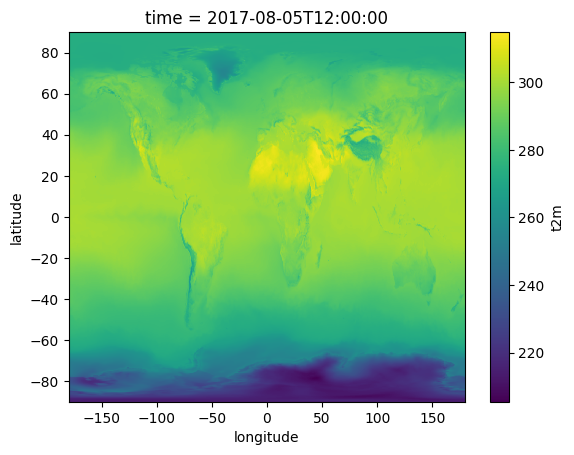

In [10]:
# Plot the earth graph
earth_graph(dataset, 't2m', 763, 1, -1, -1)

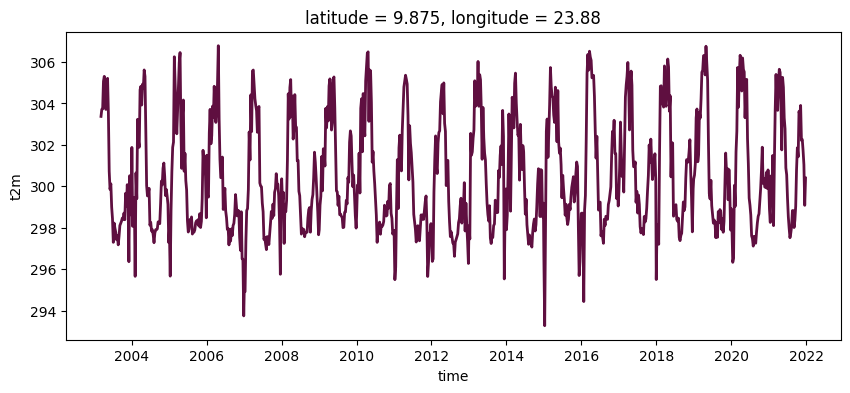

In [11]:
# Plot the trend graph
trend_graph(dataset, 't2m', 100, 900, 320, 815)

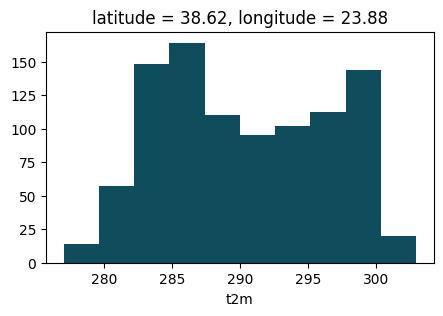

In [12]:
# Plot the graph
hist_graph(dataset, 't2m', 0, 966, 205, 815)

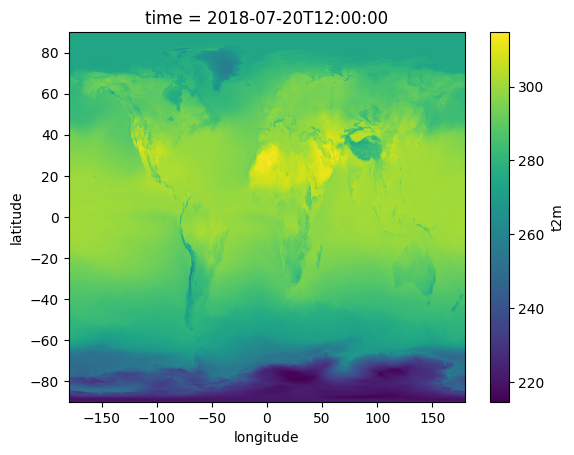

In [13]:
# Plotting the 2 metre temperature in the whole earth at specific 8-days period of time
plot_graphs(dataset, 't2m', 807, 1, -1, -1)

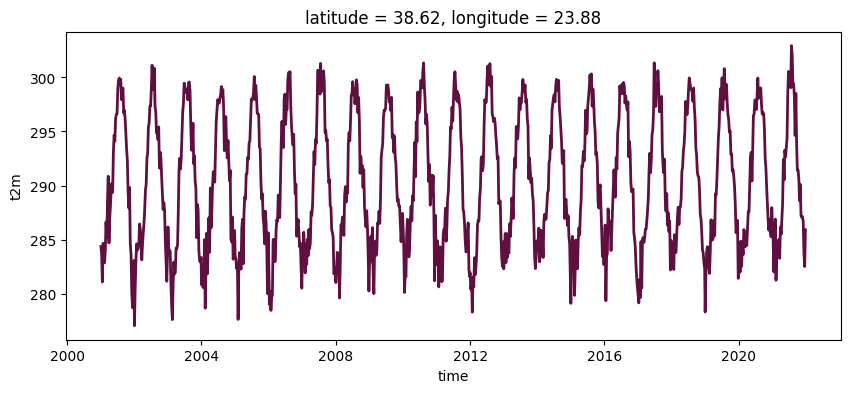

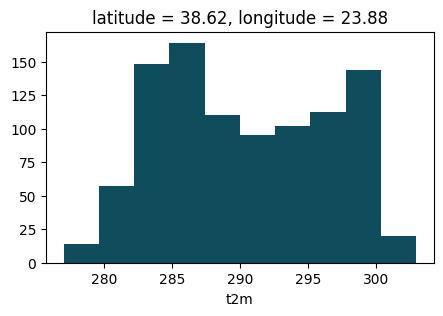

In [14]:
# Plotting the 2 metre temperature for a specific pixel (815x205 --> Greece) in the dataset for all years between 2001 and 2021. We can plot both the time-series of the temperature and a histogram of the values.
plot_graphs(dataset, 't2m', 0, 966, 205, 815)

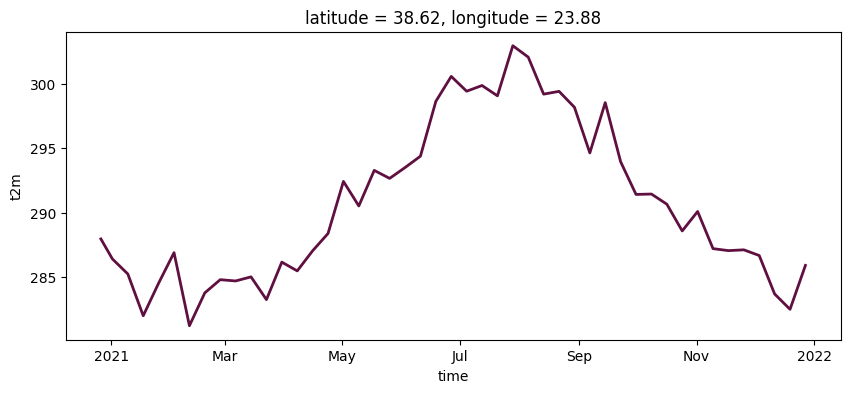

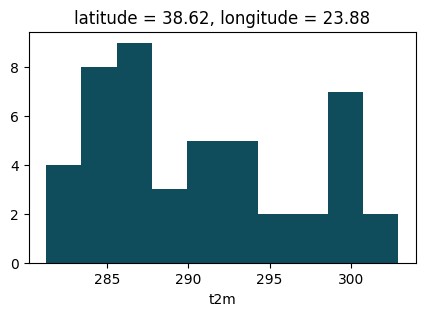

In [15]:
# Plotting the 2 metre temperature for a specific pixel (815x205 --> Greece) in the dataset for all periods in the year 2021.
plot_graphs(dataset, 't2m', 919, 47, 205, 815)

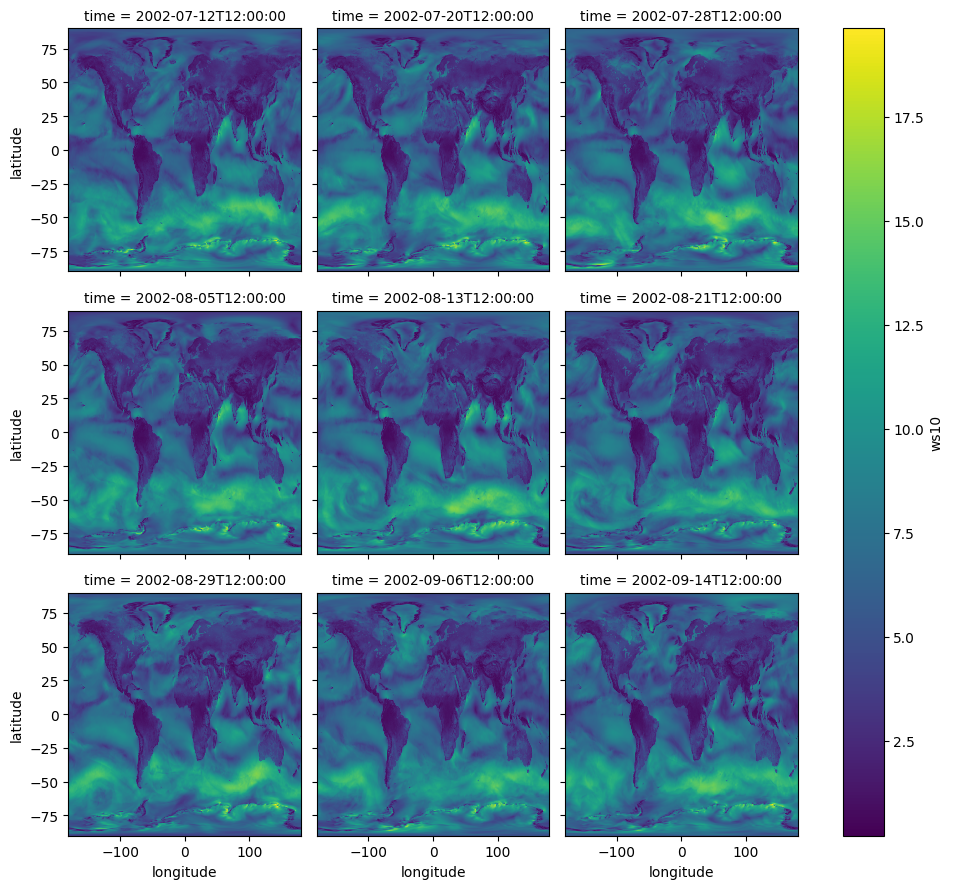

In [16]:
# Plotting the wind speed for the whole earth for a series of 8-days time periods.
plot_graphs(dataset, 'ws10', 70, 9, -1, -1, col_wrap=3)

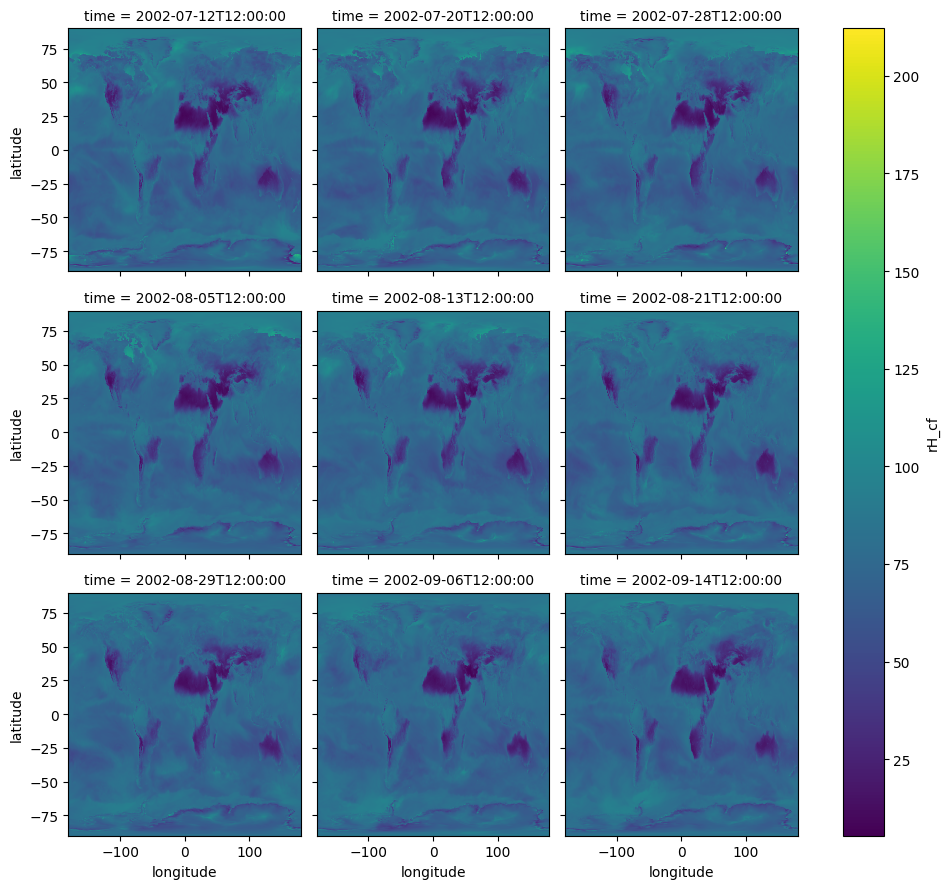

In [17]:
# Plotting the relative humidity for the whole earth for the same time periods as above.
plot_graphs(dataset, 'rH_cf', 70, 9, -1, -1, col_wrap=3)

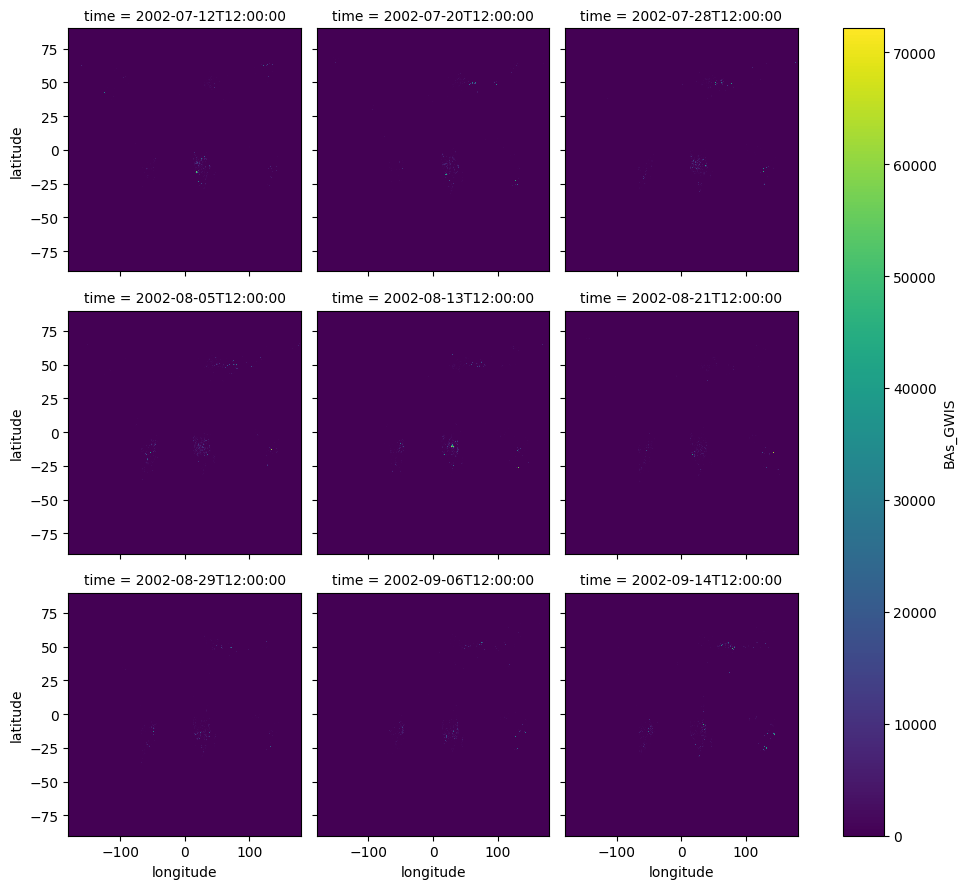

In [18]:
# Plotting the BurntArea for the whole earth for the same time periods as above.
plot_graphs(dataset, 'BAs_GWIS', 70, 9, -1, -1, col_wrap=3)